In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_windy(Q=None, path=None, saveimg=None):
    """Plot windy gridworld.

    Will plot optimal action for each cell, according to 'Q'
    and blue line following 'path' parameter

    Params:
        Q    - optional, dictionary mappting [(x,y),action] -> float
        path - optional, list [(x1,y1), (x2,y2), ...] of agent steps
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim(-.5, 9.5)
    ax.set_ylim(-.5, 6.5)
    ax.set_yticks([])
    ax.set_xticks(     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.set_xticklabels([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])

    ax.text(0, 3, 'S', fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax.text(7, 3, 'G', fontsize=18, horizontalalignment='center', verticalalignment='center')

    for x in range(10):
        for y in range(7):
            ax.add_patch(patches.Rectangle([x-0.5, y-0.5], 1, 1, fill=False))  # cells

            if Q is not None:
                params = {'head_width':0.2, 'head_length':0.2, 'color':'gray', 'alpha':.2}
                A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])  # pick best action
                if A_star == 3:    ax.arrow(x, y, 0,  .1, **params)  # up
                elif A_star == 1:  ax.arrow(x, y, 0, -.1, **params)  # down
                elif A_star == 0:  ax.arrow(x, y, -.1, 0, **params)  # left
                elif A_star == 2:  ax.arrow(x, y,  .1, 0, **params)  # right

    if path is not None:
        for i in range(len(path)-1):
            x, y = path[i]
            x_, y_ = path[i+1]
            ax.plot([x, x_], [y, y_], color='blue', alpha=1.)

    plt.tight_layout()
    if saveimg is not None:
        plt.savefig(saveimg)
    plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [7]:
def sarsa(env, ep, gamma, alpha, eps):
    """Sarsa (on-policy TD control)

    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)

    Q = defaultdict(float)  # default zero for all, terminal MUST be zero

    for _ in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            S, A = S_, A_
            if done: break

    return Q

In [8]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [9]:
class WindyGridworld:
    def __init__(self):
        self.act_space = [0, 1, 2, 3]  # LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self.reset()

    def reset(self):
        self._x, self._y = 0, 3        # agent initial position
        return (0, 3)

    def step(self, action):
        # actions: LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self._x, self._y = self.transition(self._x, self._y, action)

        if self._x == 7 and self._y == 3:        # GOAL reached
            return (self._x, self._y), -1, True  # observation, reward, done
        return (self._x, self._y), -1, False     # obs, rew, done

    def transition(self, x, y, action):
        """Perform transition from [x,y] given action"""

        if x in [3,4,5,8]:  y += 1    # windy
        if x in [6,7]:      y += 2    # woo, very windy

        if action == 0:    x -= 1     # left
        elif action == 1:  y -= 1     # down
        elif action == 2:  x += 1     # right
        elif action == 3:  y += 1     # up
        else: raise ValueError('Action must be in [0,1,2,3]')

        x = np.clip(x, 0, 9)   # x range is [0..9]
        y = np.clip(y, 0, 6)   # y range is [0..6]
        return x, y

    def get_path(self, Q):
        x, y = 0, 3       # agent starting position
        path = [(x, y)]   # save starting position
        for _ in range(100):  # limit steps in case policy is loopy
            A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])   # pick best action
            x, y = self.transition(x, y, A_star)         # take one step
            path.append((x,y))                            # save to path
            if x == 7 and y == 3:  break                 # if goal: break
        return path

In [10]:
env = WindyGridworld()

In [11]:
Q = sarsa(env, 10000, gamma=1., alpha=.5, eps=.1)

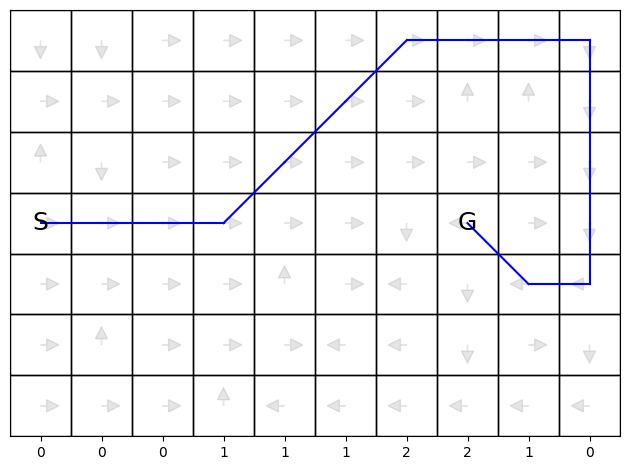

In [12]:
optimal_path = env.get_path(Q)
plot_windy(Q, optimal_path)

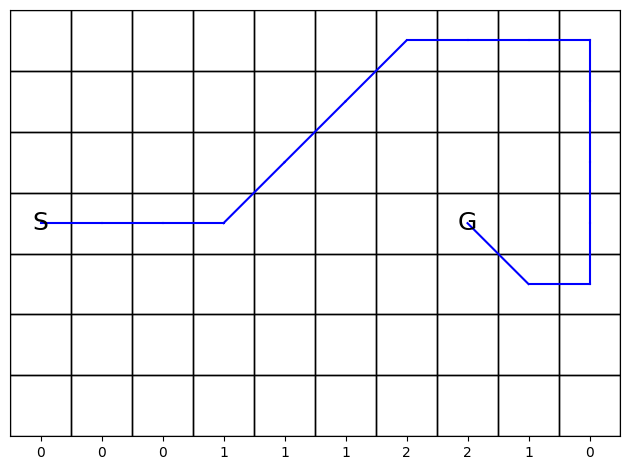

In [13]:
plot_windy(Q=None, path=optimal_path, saveimg=None)  # 'assets/fig_0604a.png'

In [14]:
def sarsa_ext(env, ep, gamma, alpha, eps, max_time_steps=None):
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)

    hist_ep = []   # current episode nb saved on each time step

    Q = defaultdict(float)  # default zero for all, terminal MUST be zero

    for current_episode in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            S, A = S_, A_

            # Change! keep track of episode number history
            hist_ep.append(current_episode)
            if max_time_steps is not None:
                if len(hist_ep) >= max_time_steps:
                    return Q, hist_ep

            if done: break

    return Q, hist_ep

In [15]:
Q, hist_ep = sarsa_ext(env, 10000, gamma=1., alpha=.5, eps=.1, max_time_steps=8000)

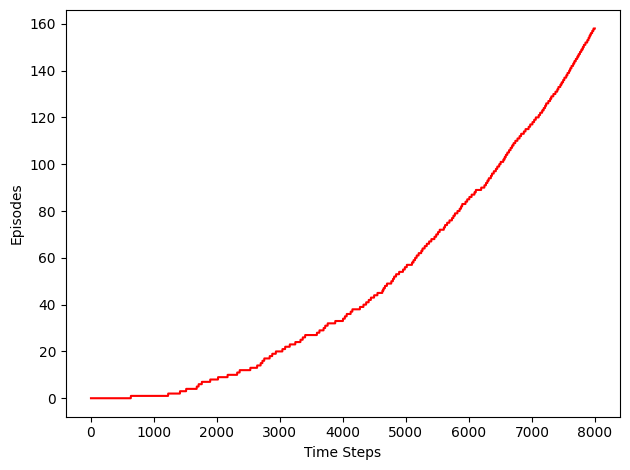

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(hist_ep, color='red')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Episodes')
plt.tight_layout()
plt.show()